In [15]:
import numpy as np
import pandas as pd
from sklearn.multioutput import RegressorChain
import os
import sys
from yellowbrick.model_selection import ValidationCurve

sys.path.append('../')  # TODO fix these imports properly
from models.final_estimator import SingleTaskEstimator
from models.personality_estimators import PersonalityMLPRegressor, PersonalityTreeRegressor
#from models.age_estimator import AgeClassifier
from models.gender_estimator import TreeEnsembleEstimator
from models.baselines import MajorityClassifier, MeanRegressor
from utils.data_processing import parse_input, split_data

input_path = '../../../new_data/Train'

MODEL_MAPPING = {
    'baseline': SingleTaskEstimator(
        age_clf=MajorityClassifier(),
        gender_clf=MajorityClassifier(),
        ope_reg=MeanRegressor(),
        con_reg=MeanRegressor(),
        ext_reg=MeanRegressor(),
        agr_reg=MeanRegressor(),
        neu_reg=MeanRegressor()
    ),
    'gender_only': SingleTaskEstimator(
        age_clf=MajorityClassifier(),
        gender_clf=TreeEnsembleEstimator(),
        ope_reg=MeanRegressor(),
        con_reg=MeanRegressor(),
        ext_reg=MeanRegressor(),
        agr_reg=MeanRegressor(),
        neu_reg=MeanRegressor()
    ),
    'personality_baseline': SingleTaskEstimator(
        age_clf=MajorityClassifier(),
        gender_clf=TreeEnsembleEstimator(),
        ope_reg=PersonalityTreeRegressor(150, 30),
        con_reg=PersonalityTreeRegressor(20, None),
        ext_reg=PersonalityTreeRegressor(25, None),
        agr_reg=PersonalityTreeRegressor(120, 30),
        neu_reg=PersonalityTreeRegressor(10, 30)
    ),

}

In [2]:
X, y = parse_input(input_path)

In [3]:
model_name = 'personality_baseline'
model = MODEL_MAPPING[model_name]

In [4]:
Xtrain, Xtest, ytrain, ytest = split_data(X,y)

../utils/data_processing.py:147: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  X_image_train, X_image_test = X['image'].loc[train_ix], X['image'].loc[test_ix]


In [5]:
model.fit(Xtrain, ytrain)
model.eval(Xtest, ytest)

Trained gender classifier.
Trained ope classifier.
Trained con classifier.
Trained ext classifier.
Trained agr classifier.
Trained neu classifier.
Trained age classifier.
The age accuracy is: 0.0
               The gender accuracy is: 0.7963157894736842
               The ope rmse is: 0.6331312924537218
)              The con rmse is: 0.7025524820098006
)              The ext rmse is: 0.8016301268850574
)              The agr rmse is: 0.6577510333775411
)              The neu rmse is: 0.7990276238895204



/home/mila/teaching/user17/.conda/envs/personalities/lib/python3.7/site-packages/sklearn/metrics/classification.py:182: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


{'gender': 0.7963157894736842,
 'ope': 0.6331312924537218,
 'con': 0.7025524820098006,
 'ext': 0.8016301268850574,
 'agr': 0.6577510333775411,
 'neu': 0.7990276238895204,
 'age': 0.0}

In [12]:
features, labels = X['text'], y

In [14]:
y

,age,gender,ope,con,ext,agr,neu
userid,,,,,,,
0000e06e07496624211632e8e264126c,1,1.0,4.00,4.75,4.50,2.50,3.75
000235a2ba2f48231b7d24e1f08d7878,1,0.0,3.80,3.30,3.80,3.70,1.80
000c4b6e2468f7d528876fd1a6dffd4c,1,0.0,4.10,2.85,2.15,3.20,3.65
001187432d2a247562082cd0000dec40,1,0.0,3.50,3.75,4.00,4.38,1.88
001494c3b74f124a2e3435fff17f376b,1,1.0,4.50,4.25,4.00,4.50,4.50
...,...,...,...,...,...,...,...
ffb0a8b51dd1d644bcf3d85f42dcd7d7,0,0.0,3.65,3.26,3.65,3.65,2.95
ffb2830257138d30925a345f7c404d16,1,0.0,3.20,3.80,3.65,4.15,2.40
ffd1a5148d201815453c698214c627c0,1,0.0,3.75,3.00,3.50,2.50,2.00


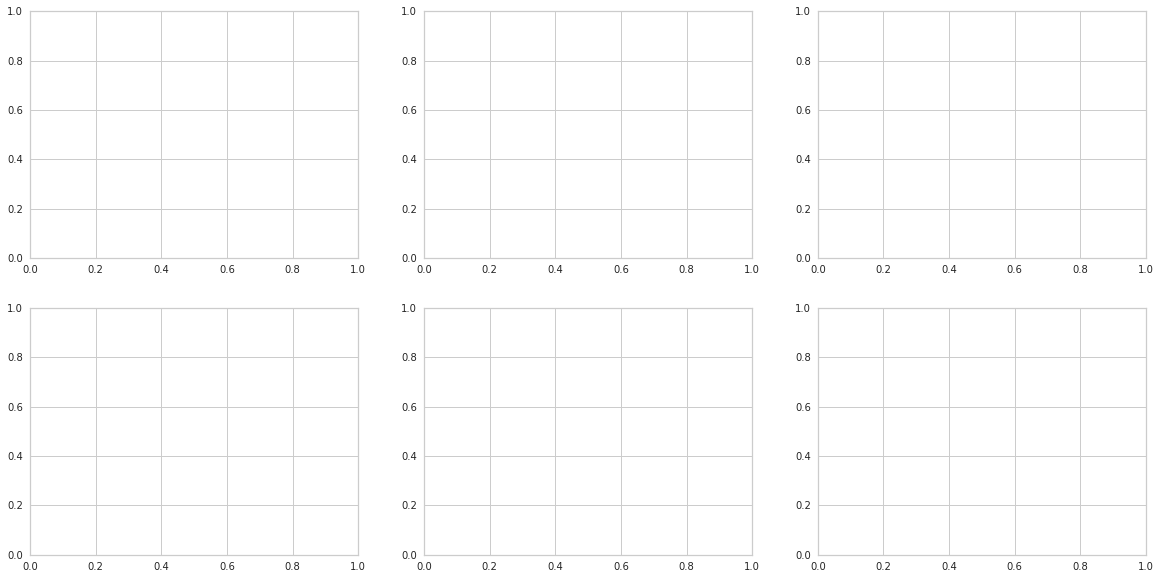

In [51]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

model = make_pipeline(StandardScaler(), PCA(n_components=30), GradientBoostingRegressor())

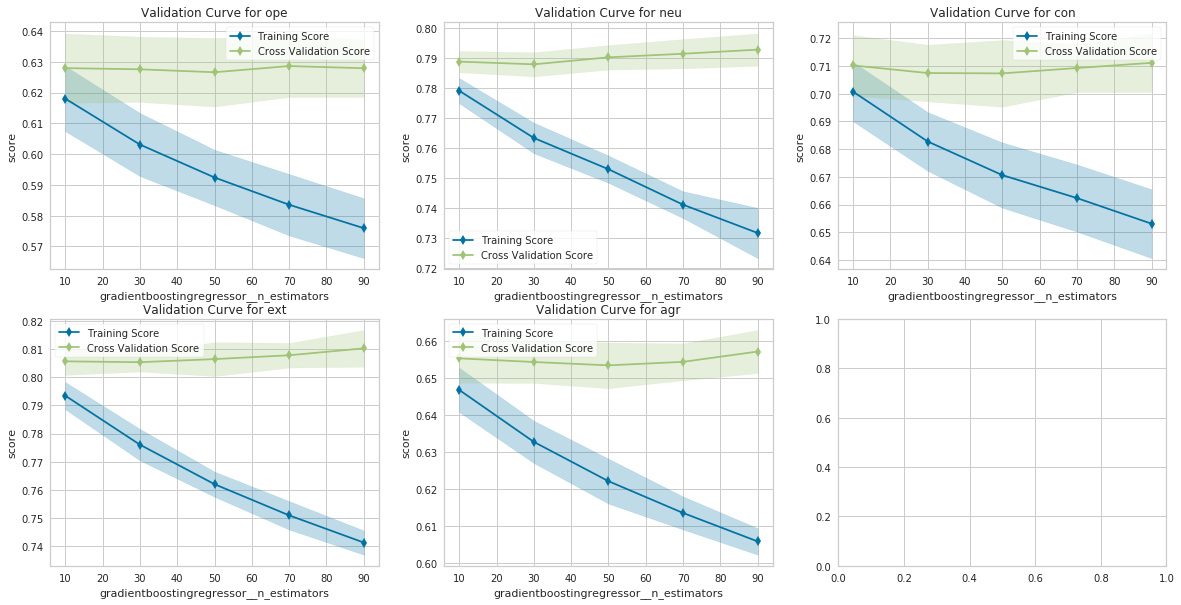

In [75]:
fig, ax = plt.subplots(2,3, figsize=(20,10))

for i, task in enumerate(['ope', 'neu', 'con', 'ext', 'agr']):
    viz = ValidationCurve(
        model, param_name="gradientboostingregressor__n_estimators",
        param_range=np.arange(10,110,20), cv=2, scoring=make_scorer(rmse),
        ax=ax[i//3][i%3], title="Validation Curve for {}".format(task))
    # Fit and show the visualizer
    viz.fit(features, y[task])
    viz.finalize()
    
plt.show()

In [76]:
fig.savefig('personality_cv.png')